In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import re, os, time

# 实现步骤
## 1、预处理
## 2、搭建模型
### 2.1、encoder
### 2.2、attention
### 2.3、decoder
### 2.5、loss & optimizer
### 2.6、train
## 3、evaluation搭建模型
### 3.1、given sentence，return translated results
### 3.2、visualize results（attention）

* `https://tensorflow.google.cn/tutorials/text/nmt_with_attention?hl=zh-cn`


In [2]:
# 下载文件
#  http://www.manythings.org/anki/ 这个数据集中有很多种语言可供选择。我们将使用英语 - 西班牙语数据集。

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [3]:

# 将 unicode 文件转换为 ascii
import unicodedata
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) 
                   #NFD是一种方法，如果unicode由多个ascii码组成，就把它拆开
                   #Mn是西班牙语中的重音，下面语句就是去除重音
                        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)#前后加空格
    w = re.sub(r'[" "]+', " ", w)#空格去重

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
# 测试
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))#.encode('utf-8'))

<start> may i borrow this book ? <end>
<start> ¿ puedo tomar prestado este libro ? <end>


In [5]:
def parse_data(filename):
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    sentence_pairs = [line.split('\t') for line in lines]
    preprocess_sentence_pairs = [(preprocess_sentence(en), preprocess_sentence(sp)) for en, sp in sentence_pairs]
    
    return zip(*preprocess_sentence_pairs)#解包和zip
en_dataset, sp_dataset = parse_data(path_to_file)
print(en_dataset[-1])
print(sp_dataset[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [6]:
# 测试 解包和zip
a = [(1,2),(3,4),(5,6)]
print(*a)#解包就是把每个元组解开
# c,d,e = zip(a)
# print(c, d, e)
c, d  = zip(*a)解包和zip后效果
print(c, d)

SyntaxError: invalid syntax (<ipython-input-6-1cd57747b164>, line 6)

In [7]:
# 转换成id
# https://www.cnblogs.com/xianhan/p/10834712.html
def tokenizer(lang):
    '''将文本转化为id，并同时返回转化器'''
    lang_tokenizer = keras.preprocessing.text.Tokenizer(
            num_words=None,#限制词表数量，整数，none代表不限制
            filters = '',#过滤掉的词语
            split = ' '#按照空格分割              
    )#实例化
    lang_tokenizer.fit_on_texts(lang)#传入数据
    tensor = lang_tokenizer.texts_to_sequences(lang)#调用方法转换为seq
    tensor = keras.preprocessing.sequence.pad_sequences(tensor,padding = 'post')#做padding
    return tensor, lang_tokenizer

input_tensor, input_tokenizer = tokenizer(sp_dataset[:30000])#使用部分样本，测试
output_tensor, output_tokenizer = tokenizer(en_dataset[:30000])

def max_length(tensor):
    '''获取最长的样本长度'''
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
print(max_length_input, max_length_output)
print(len(input_tensor[2]))#padding之后所有样本长度相等

16 11
16


In [8]:
from sklearn.model_selection import train_test_split

input_train, input_eval, output_train, output_eval = train_test_split(
            input_tensor , output_tensor, test_size=0.2)

len(input_train), len(input_eval), len(output_train), len(output_eval)

(24000, 6000, 24000, 6000)

In [9]:
# 验证tokenizer是否正常工作
def convert(example, tokenizer):
    for t in example:
        if t !=0:
            print('%d --> %s' %(t, tokenizer.index_word[t]))

convert(input_train[0], input_tokenizer)
print()
convert(output_train[0], output_tokenizer)

1 --> <start>
1729 --> subete
39 --> las
8416 --> mangas
3 --> .
2 --> <end>

1 --> <start>
4443 --> roll
50 --> up
31 --> your
4444 --> sleeves
3 --> .
2 --> <end>


In [10]:
def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle = False):
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
    if shuffle:
        detaset = dataset.shuffle(len(input_tensor))
    dataset = dataset.repeat(epochs).batch(batch_size,drop_remainder = True)
    return dataset

batch_size = 64
epochs = 20
train_dataset = make_dataset(input_train, output_train, batch_size, epochs, shuffle=True)
eval_dataset = make_dataset(input_eval, output_eval, batch_size, 1) 

        

In [11]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

(64, 16)
(64, 11)
tf.Tensor(
[[   1 1729   39 ...    0    0    0]
 [   1    8   47 ...    0    0    0]
 [   1 5875   33 ...    0    0    0]
 ...
 [   1    6   45 ...    0    0    0]
 [   1 1146 1506 ...    0    0    0]
 [   1   59   17 ...    0    0    0]], shape=(64, 16), dtype=int32)
tf.Tensor(
[[   1 4443   50   31 4444    3    2    0    0    0    0]
 [   1    4  164   12  182   15   36    3    2    0    0]
 [   1  288   31  324    3    2    0    0    0    0    0]
 [   1   14 4330    9 4331    3    2    0    0    0    0]
 [   1   22    6   29    9   83    7    2    0    0    0]
 [   1   14    8   21  507    3    2    0    0    0    0]
 [   1    5  137 2030    3    2    0    0    0    0    0]
 [   1  102   58    3    2    0    0    0    0    0    0]
 [   1   20    8   68  168    3    2    0    0    0    0]
 [   1   10   51  160 2399    3    2    0    0    0    0]
 [   1    4   18   79 3446    3    2    0    0    0    0]
 [   1  202    5    3    2    0    0    0    0    0    0]
 [   1

# 搭建模型

In [12]:
# 定义超参数
embedding_units = 256
units = 1024
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

## 1、Encoder构建

In [13]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_units, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = keras.layers.GRU(self.encoding_units, 
                                               return_sequences=True,
                                               return_state=True,
                                               recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state  = self.gru(x,  initial_state = hidden)
        return output, state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

    
encoder = Encoder(input_vocab_size, embedding_units,
                             units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(x, sample_hidden)
print('sample_output.shape:', sample_output.shape)
print('sample_hidden.shape:', sample_hidden.shape)

sample_output.shape: (64, 16, 1024)
sample_hidden.shape: (64, 1024)


## 2、attention构建

In [14]:
# # 官网
# class BahdanauAttention(tf.keras.layers.Layer):
#     def __init__(self, units):
#         super(BahdanauAttention, self).__init__()
#         self.W1 = tf.keras.layers.Dense(units)
#         self.W2 = tf.keras.layers.Dense(units)
#         self.V = tf.keras.layers.Dense(1)

#     def call(self, query, values):
#         # 隐藏层的形状 == （批大小，隐藏层大小）
#         # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
#         # 这样做是为了执行加法以计算分数  
#         hidden_with_time_axis = tf.expand_dims(query, 1)

#         # 分数的形状 == （批大小，最大长度，1）
#         # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
#         # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
#         score = self.V(tf.nn.tanh(
#         self.W1(values) + self.W2(hidden_with_time_axis)))

#         # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
#         attention_weights = tf.nn.softmax(score, axis=1)

#         # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
#         context_vector = attention_weights * values
#         context_vector = tf.reduce_sum(context_vector, axis=1)

#         return context_vector, attention_weights

# attention_layer = BahdanauAttention(10)
# attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

# print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
# print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [15]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
    
    def call(self, decoder_hidden, encoder_outputs):
        #decoder_hidden.shape:(batch_size, units)
        #enconder_outputs.shape:(batch_size,length,units)
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)
        #before V:(batch_size, length, unirs)
        #after V:(batch_size, length, 1)
        score = self.V(
            tf.nn.tanh(
                self.W1(encoder_outputs) +self.W2(decoder_hidden_with_time_axis)))
        #shape:(batch_size, length, 1)
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        #cintext_vertor.shape:(batch_size, length, units)
        context_vector = attention_weights * encoder_outputs
        
        #cintext_vertor.shape:(batch_size, units)        
        context_vector = tf.reduce_sum(context_vector, axis =1)
        
        return context_vector, attention_weights
attention_model = BahdanauAttention(units = 10)
attention_results, attention_weights = attention_model(sample_hidden, sample_output)

print('attention_results.shape: (batch size, units)', attention_results.shape)
print('attention_weights.shape: (batch_size, sequence_length, 1) ',attention_weights.shape)

attention_results.shape: (batch size, units) (64, 1024)
attention_weights.shape: (batch_size, sequence_length, 1)  (64, 16, 1)


## 3、decoder构建

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_units, decoding_units, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_units)
        self.gru = tf.keras.layers.GRU(self.decoding_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 用于注意力
        self.attention = BahdanauAttention(self.decoding_units)

    def call(self, x, hidden, encoding_output):
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, encoding_output)
        # x 在通过嵌入层前形状==（批大小，1）
        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(combined_x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        output = self.fc(output)

        return output, state, attention_weights

decoder = Decoder(output_vocab_size, embedding_units, units, batch_size)

outputs = decoder(tf.random.uniform((batch_size,1)),
                         sample_hidden,
                         sample_output)

sample_decoder_output, decoder_hidden, decoder_aw = decoder(tf.random.uniform((batch_size, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab_size) {}'.format(sample_decoder_output.shape))
print('decoder_hidden.shape:', decoder_hidden.shape)
print('decoder_aw.shape:', decoder_aw.shape)

Decoder output shape: (batch_size, vocab_size) (64, 4935)
decoder_hidden.shape: (64, 1024)
decoder_aw.shape: (64, 16, 1)


## 定义优化器和损失函数

In [17]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    #mask目的是去掉padding对应的损失函数
#     equel看是否是0，是0返回True(1)
#     logical_not取反，0返回False(0)
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask# 乘以mask后padding就不计入了

    return tf.reduce_mean(loss_)#最后做平均

## 检查点（基于对象保存）

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# 训练
## 1、将 输入 传送至 编码器，编码器返回 编码器输出 和 编码器隐藏层状态。
## 2、将编码器输出、编码器隐藏层状态和解码器输入（即 开始标记）传送至解码器。
## 3、解码器返回 预测 和 解码器隐藏层状态。
## 4、解码器隐藏层状态被传送回模型，预测被用于计算损失。
## 5、使用 教师强制 （teacher forcing） 决定解码器的下一个输入。
## 6、教师强制 是将 目标词 作为 下一个输入 传送至解码器的技术。
## 7、最后一步是计算梯度，并将其应用于优化器和反向传播。

In [19]:
# # 官网内容
# @tf.function
# def train_step(inp, targ, encoding_hidden):
#   loss = 0

#   with tf.GradientTape() as tape:
#     encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)

#     decoding_hidden = encoding_hidden

#     decoding_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

#     # 教师强制 - 将目标词作为下一个输入
#     for t in range(1, targ.shape[1]):
#       # 将编码器输出 （enc_output） 传送至解码器
#       predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_output)

#       loss += loss_function(targ[:, t], predictions)

#       # 使用教师强制
#       decoding_input = tf.expand_dims(targ[:, t], 1)

#   batch_loss = (loss / int(targ.shape[1]))

#   variables = encoder.trainable_variables + decoder.trainable_variables

#   gradients = tape.gradient(loss, variables)

#   optimizer.apply_gradients(zip(gradients, variables))

#   return batch_loss

In [20]:
# 官网内容
@tf.function
def train_step(inp, targ, encoding_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        encoding_outputs, encoding_hidden = encoder(inp, encoding_hidden)

        decoding_hidden = encoding_hidden

#     dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    
        for t in range(0, targ.shape[1]-1):
          # 将编码器输出 （enc_output） 传送至解码器
            decoding_input = tf.expand_dims(targ[:, t], 1)

            predictions, decoding_hidden, _ = decoder(
                decoding_input, decoding_hidden, encoding_outputs)

            loss += loss_function(targ[:, t+1], predictions)


    batch_loss = loss / int(targ.shape[1])

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [21]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()

    encoding_hidden = encoder.initialize_hidden_state()#初始化hidden
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):#遍历datasets
        batch_loss = train_step(inp, targ, encoding_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6024
Epoch 1 Batch 100 Loss 2.2019
Epoch 1 Batch 200 Loss 1.8667
Epoch 1 Batch 300 Loss 1.6184
Epoch 1 Batch 400 Loss 1.6638
Epoch 1 Loss 1.9362
Time taken for 1 epoch 42.016186237335205 sec

Epoch 2 Batch 0 Loss 1.3204
Epoch 2 Batch 100 Loss 1.4311
Epoch 2 Batch 200 Loss 1.2781
Epoch 2 Batch 300 Loss 1.1014
Epoch 2 Batch 400 Loss 1.0440
Epoch 2 Loss 1.2269
Time taken for 1 epoch 30.838979959487915 sec

Epoch 3 Batch 0 Loss 0.6815
Epoch 3 Batch 100 Loss 0.9803
Epoch 3 Batch 200 Loss 0.8568
Epoch 3 Batch 300 Loss 0.7592
Epoch 3 Batch 400 Loss 0.6246
Epoch 3 Loss 0.7615
Time taken for 1 epoch 30.45903253555298 sec

Epoch 4 Batch 0 Loss 0.3300
Epoch 4 Batch 100 Loss 0.6270
Epoch 4 Batch 200 Loss 0.5801
Epoch 4 Batch 300 Loss 0.4762
Epoch 4 Batch 400 Loss 0.3710
Epoch 4 Loss 0.4695
Time taken for 1 epoch 30.754446029663086 sec

Epoch 5 Batch 0 Loss 0.1661
Epoch 5 Batch 100 Loss 0.3726
Epoch 5 Batch 200 Loss 0.3739
Epoch 5 Batch 300 Loss 0.3027
Epoch 5 Batch 400 Loss 

## 翻译
### 评估函数类似于训练循环，不同之处在于在这里我们不使用 教师强制。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
### 当模型预测 结束标记 时停止预测。
### 存储 每个时间步的注意力权重。
#### 请注意：对于一个输入，编码器输出仅计算一次。

In [27]:
def evaluate(input_sentence):
    attention_matrix = np.zeros((max_length_output, max_length_input))

    input_sentence = preprocess_sentence(input_sentence)

    inputs = [input_tokenizer.word_index[token] for token in input_sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_input,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    encoding_hidden =tf.zeros((1, units))
    encoding_output, encoding_hidden = encoder(inputs, encoding_hidden)

    decoding_hidden = encoding_hidden
        
    decoding_input = tf.expand_dims([output_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_output):
        predictions, dec_hidden, attention_weights = decoder(decoding_input,
                                                             decoding_hidden,
                                                             encoding_output)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += output_tokenizer.index_word[predicted_id] + ' '

        if output_tokenizer.index_word[predicted_id] == '<end>':
            return result, input_sentence, attention_matrix

        # 预测的 ID 被输送回模型
        decoding_input = tf.expand_dims([predicted_id], 0)

    return result, input_sentence, attention_matrix

In [23]:
# 注意力权重制图函数
def plot_attention(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + input_sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [29]:
def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)

    print('Input: %s' % (input_sentence))
    print('Predicted translation: {}'.format(results))

    attention_matrix = attention_matrix[:len(results.split(' ')), 
                                                  :len(input_sentence.split(' '))]
    plot_attention(attention_matrix, input_sentence.split(' '), results.split(' '))

# 恢复最新的检查点并验证

In [25]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it it it it it it it it it it it 


NameError: name 'ticker' is not defined

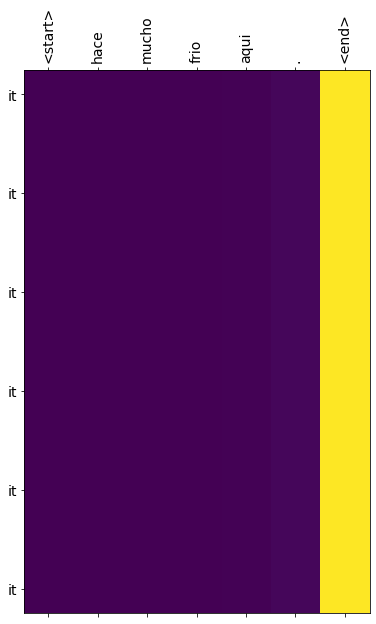

In [32]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this this this this this this this this this this this 


NameError: name 'ticker' is not defined

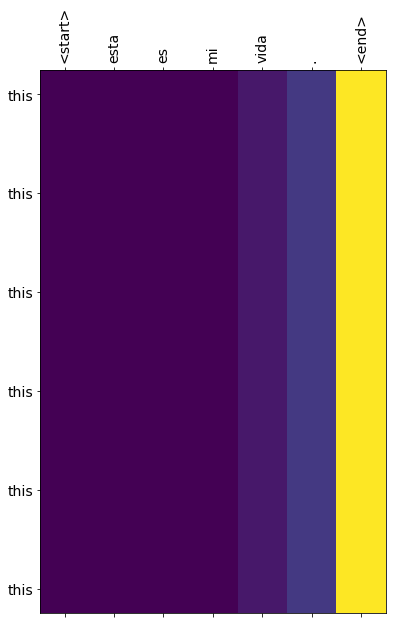

In [33]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you are you are you are you are you are 


NameError: name 'ticker' is not defined

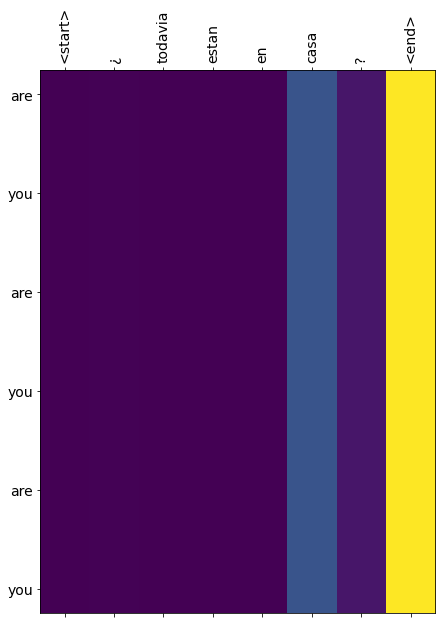

In [34]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try try try try try try try try try try try 


NameError: name 'ticker' is not defined

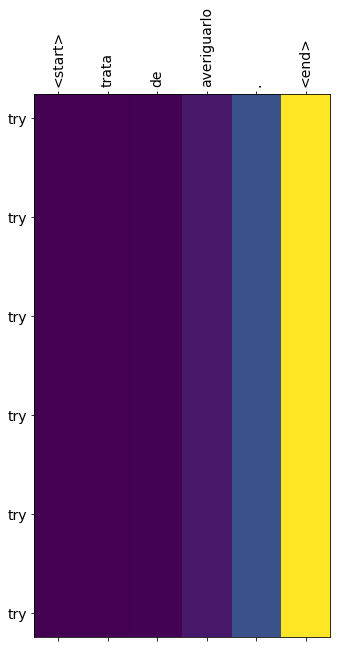

In [35]:
# 错误的翻译
translate(u'trata de averiguarlo.')